In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = "/home/clairegayral/Documents/openclassroom/data/"

## my .py : 
import read_csv
import preprocess
import list_from_data_field 
import missing_values_treatment

My preprocess consisted in : 
* Read the data : I only kept data with the "nutrition score" for this analyse,
* Drop the columns with too many missing values
* Select the variables that will interest me : the nutrition variable, with name of the product, its code reference, country of sell, and name of the person that inter it in the open food fact base.
* Merge the two columns that are about the palm oil ingredients.
* Remove outliers (from the semantic of columns, and compared to the other values)

In [33]:
##
## read data : 
##

# read_csv.save_csv()
df_original = pd.read_csv(data_path+"projet2/df_original.csv", 
                          low_memory=False, index_col=0)

##
## drop empty columns
##

nan_repartition = df_original.isna().sum(axis=0)
# nan_threshold = nan_repartition.mean()
nan_threshold = nan_repartition.quantile(0.75)
# df = preprocess.preprocess_drop_col_nan(df_original, nan_threshold)
df = df_original.copy()
##
## select variables 
##

list_of_nutri_facts = list_from_data_field.list_of_nutri_facts
interest_var = pd.Index(["code","product_name","creator","countries",
                         "additives_n","ingredients_from_palm_oil"])
interest_var = interest_var.append(df.columns.intersection(list_of_nutri_facts))
df = preprocess.select_columns(df, interest_var)

##
## set dtype : 
##

df = preprocess.set_dtypes(df)

##
## merge "from palm oil" 
##

df = preprocess.merge_palm_oil_cols(df)

In [18]:
energy_var =  ['energy-kj_100g', 'energy-kcal_100g', 'energy_100g',
               'fat_100g','saturated-fat_100g']

var_rescale_100g = ['monounsaturated-fat_100g','polyunsaturated-fat_100g',
                     'omega-3-fat_100g','omega-6-fat_100g', 'omega-9-fat_100g',
                     'trans-fat_100g','cholesterol_100g','carbohydrates_100g',
                     'sugars_100g','starch_100g','polyols_100g','fiber_100g', 
                     'proteins_100g','casein_100g','serum-proteins_100g',
                     'nucleotides_100g','sodium_100g','alcohol_100g',
                     'vitamin-a_100g','vitamin-d_100g','vitamin-e_100g',
                     'vitamin-k_100g','vitamin-c_100g','vitamin-b1_100g',
                     'vitamin-b2_100g','vitamin-pp_100g','vitamin-b6_100g',
                     'vitamin-b9_100g','vitamin-b12_100g','biotin_100g',
                     'pantothenic-acid_100g', 'silica_100g','bicarbonate_100g',
                     'potassium_100g','chloride_100g','calcium_100g',
                     'phosphorus_100g', 'iron_100g','magnesium_100g',
                     'zinc_100g','copper_100g', 'manganese_100g',
                     'fluoride_100g', 'selenium_100g','chromium_100g',
                      'molybdenum_100g','iodine_100g', 'caffeine_100g',
                     'taurine_100g', 'ph_100g','fruits-vegetables-nuts_100g']
                        
possible_val_dict = { # var_rescale_100g
                     'monounsaturated-fat_100g':[0,100],
                     'polyunsaturated-fat_100g':[0,100],
                     'omega-3-fat_100g':[0,100], 'omega-6-fat_100g':[0,100],
                     'omega-9-fat_100g':[0,100], 'trans-fat_100g':[0,100], 
                     'cholesterol_100g':[0,100],'carbohydrates_100g':[0,100],
                     'sugars_100g':[0,100], 'starch_100g':[0,100], 
                     'polyols_100g':[0,100],'fiber_100g':[0,100], 
                     'proteins_100g':[0,100], 'casein_100g':[0,100],
                     'serum-proteins_100g':[0,100], 'nucleotides_100g':[0,100],
                     'sodium_100g':[0,100],'alcohol_100g':[0,100], 
                     'vitamin-a_100g':[0,1], 'vitamin-d_100g':[0,1],
                     'vitamin-e_100g':[0,1], 'vitamin-k_100g':[0,1],
                     'vitamin-c_100g':[0,1],'vitamin-b1_100g':[0,1],
                     'vitamin-b2_100g':[0,1], 'vitamin-pp_100g':[0,1],
                     'vitamin-b6_100g':[0,1], 'vitamin-b9_100g':[0,1],
                     'vitamin-b12_100g':[0,1],'biotin_100g':[0,100],
                     'pantothenic-acid_100g':[0,10], 'silica_100g':[0,100],
                     'bicarbonate_100g':[0,10], 'potassium_100g':[0,100],
                     'chloride_100g':[0,100],'calcium_100g':[0,100],
                     'phosphorus_100g':[0,100], 'iron_100g':[0,100],
                     'magnesium_100g':[0,100],'zinc_100g':[0,100],
                     'copper_100g':[0,100], 'manganese_100g':[0,100],
                     'fluoride_100g':[0,100], 'selenium_100g':[0,100], 
                     'chromium_100g':[0,100], 'molybdenum_100g':[0,100], 
                     'iodine_100g':[0,100], 'caffeine_100g':[0,100], 
                     'taurine_100g':[0,100], 'ph_100g':[0,100],
                     'fruits-vegetables-nuts_100g':[0,100],
                      # energy_var : 
                     'energy-kj_100g':[0,25000],
                     'energy-kcal_100g':[0,5000], 'energy_100g':[0,30000],
                     'fat_100g':[0,100], 'saturated-fat_100g':[0,100],
                      # other
                     'additives_n':[0,35], 'ingredients_from_palm_oil': [0,1],
                     'carbon-footprint_100g':[0,5000],
                     'nutrition-score-fr_100g':[-20,50],'nutrition-score-uk_100g':[-5,25]}


def extract_irreg_errors_val(colname,possible_values, data):
    outliers_val = []
    col_values = data[colname].drop_duplicates().values
    ## check possible values : 
    min_value, max_value = possible_values
    for val in col_values :
        if ~np.isnan(val) :
            if (val < min_value) or (val > max_value):
                outliers_val.append(val)
#         else : 
#             print(sum(data[colname].isna()),"missing values")
#     print(len(outliers_val), "item values out of the intervall", possible_values)
    return outliers_val

def help_to_set_outliers_vals(df, colname, possible_vals):
    data = df.copy()
    fig = plt.figure(figsize=(15, 5))

    ## Histogramme global 
    ax = fig.add_subplot(1,3,1)
    nb_bins = min(50, len(np.unique(data[colname].dropna().values)))
    ax.hist(data[colname], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
    ax.set_title("before removing outliers " + colname)

    outliers = extract_irreg_errors_val(colname,possible_vals, data = data)
    print("outliers products :",np.array(data.loc[data[colname].isin(outliers), "product_name"]), "\n")
    # replace outliers by np.nan : 
    data.at[data[colname].isin(outliers)] = np.nan

    ## Histogramme : 
    ax = fig.add_subplot(1,3,2)
    nb_bins = min(50, len(np.unique(data[colname].dropna().values)))
    ax.hist(data[colname], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
    ax.set_title("after removing outliers " + colname)

    # plot values : 
    ax = fig.add_subplot(1,3,3)
    ax.plot(np.sort(data[colname]))
    return( outliers )

# def rescale_outliers100g_val(data,possible_val_dict = possible_val_dict, concerned_var = var_rescale_100g):
#     # from the hyp that the variable has been entered in mg instead of g -> rescale 
#     count_rescaled = pd.Series(np.zeros(len(data.columns)),index = data.columns)
#     for colname in data.columns.intersection(concerned_var) : 
#         col_values = data[~data[colname].isna(),colname]
#     for val in col_values :
#         if ~np.isnan(val) :
#             if (val < min_value) or (val > max_value):
#                 outliers_val.append(val)
        
        
#         min_val,max_val = possible_val_dict[colname]
#         if ()
#         outliers_val = extract_irreg_errors_val(colname,possible_val_dict[colname], data)
#         outliers_bool = data[colname].isin(outliers_val)
#         count_rescaled[colname] = sum(outliers_bool) 
#         data.at[outliers_bool, colname] = data.loc[outliers_bool, colname]/1000 
# #     print(count_rescaled[count_rescaled>0])
#     return(data)
# # preprocess2_data(possible_val_dict,data)

# def drop_outliers(data, possible_val_dict = possible_val_dict):
# #     count_outliers = pd.Series(data.isna().sum(axis = 1),index = data.index)
#     for colname in data.columns.intersection(possible_val_dict.keys()) : 
#         outliers_val = extract_irreg_errors_val(colname,possible_val_dict[colname], data)
#         outliers_index = data[colname].isin(outliers_val)
#         data.loc[outliers_index,colname] = np.nan
# #     nan_repartition = 
#     ## drop products where to more than half missing values : 
#     to_drop_products = count_outliers[count_outliers>(int(len(data.columns)/2)+1)].index
#     data.drop(to_drop_products, axis = 0, inplace = True)
#     return(data)


In [82]:
data = df.copy()
    # from the hyp that the variable has been entered in mg instead of g -> rescale 
    # count_rescaled = pd.Series(np.zeros(len(data.columns)),index = data.columns)

    for colname in data.columns.intersection(concerned_var):
        min_value, max_value = possible_val_dict[colname] 
        is_outlier = (data[colname] < min_value) | (data[colname]>max_value) | ~data[colname].isna()  
        data.at[is_outlier, colname] = data.loc[is_outlier,colname]/1000 
    #     count_rescaled[colname] = sum(is_outlier)

In [83]:
count_rescaled

code                              0.0
creator                           0.0
product_name                      0.0
countries                         0.0
additives_n                       0.0
                                ...  
ph_100g                         157.0
fruits-vegetables-nuts_100g    7476.0
carbon-footprint_100g             0.0
nutrition-score-fr_100g           0.0
nutrition-score-uk_100g           0.0
Length: 65, dtype: float64

In [ ]:

    
#     for val in col_values :
#         if (val < min_value) or (val > max_value):
            
#     outliers_val = extract_irreg_errors_val(colname,possible_val_dict[colname], data)
#     outliers_bool = data[colname].isin(outliers_val)
#     count_rescaled[colname] = sum(outliers_bool) 
#     data.at[outliers_bool, colname] = data.loc[outliers_bool, colname]/1000 
# #     print(count_rescaled[count_rescaled>0])
# return(data)

In [14]:
float_var = list_from_data_field.list_of_nutri_facts
float_var += ["additives_n", "ingredients_from_palm_oil_n","ingredients_from_palm_oil_n"]
float_var = df.columns.intersection(float_var).values


# colname ='energy-kj_100g'
# vals = [0,5000]
# # vals = possible_val_dict[colname]
# outliers_val = help_to_set_outliers_vals(df, colname, vals)
# outliers_index = df[df[colname].isin(outliers_val)].index
# df.loc[outliers_index,["product_name",colname]]

data = df.copy()
data = rescale_outliers100g_val(df)
# data = drop_outliers(data)
# data.shape

In [15]:
data = df.copy()
concerned_var = var_rescale_100g
# from the hyp that the variable has been entered in mg instead of g -> rescale 
count_rescaled = pd.Series(np.zeros(len(data.columns)),index = data.columns)
for colname in data.columns.intersection(concerned_var) : 
    print(colname)
    outliers_val = extract_irreg_errors_val(colname,possible_val_dict[colname], data)
    print(outliers_val)
    outliers_bool = data[colname].isin(possible_val_dict[colname])
    count_rescaled[colname] = sum(outliers_bool)
#     print(data[colname].loc[outliers_bool])
#     data.at[outliers_bool, colname] = data.loc[outliers_bool, colname]/1000 

monounsaturated-fat_100g
[]
polyunsaturated-fat_100g
[]
omega-3-fat_100g
[]
omega-6-fat_100g
[]
omega-9-fat_100g
[]
trans-fat_100g
[]
cholesterol_100g
[]
carbohydrates_100g
[]
sugars_100g
[]
starch_100g
[]
polyols_100g
[]
fiber_100g
[]
proteins_100g
[]
casein_100g
[]
serum-proteins_100g
[]
nucleotides_100g
[]
sodium_100g
[]
alcohol_100g
[]
vitamin-a_100g
[]
vitamin-d_100g
[]
vitamin-e_100g
[]
vitamin-k_100g
[]
vitamin-c_100g
[]
vitamin-b1_100g
[]
vitamin-b2_100g
[]
vitamin-pp_100g
[]
vitamin-b6_100g
[]
vitamin-b9_100g
[]
vitamin-b12_100g
[]
biotin_100g
[]
pantothenic-acid_100g
[]
silica_100g
[]
bicarbonate_100g
[]
potassium_100g
[]
chloride_100g
[]
calcium_100g
[]
phosphorus_100g
[]
iron_100g
[]
magnesium_100g
[]
zinc_100g
[]
copper_100g
[]
manganese_100g
[]
fluoride_100g
[]
selenium_100g
[]
chromium_100g
[]
molybdenum_100g
[]
iodine_100g
[]
caffeine_100g
[]
taurine_100g
[]
ph_100g
[]
fruits-vegetables-nuts_100g
[]


((2648, 65), (2648, 65))

In [11]:
data["ingredients_from_palm_oil"]
# help_to_set_outliers_vals(df, colname, possible_val_dict[colname])
# product_name = ['All-in Mix pour pain omega 3', 'France Lait pour nourrissons 0-6 mois',
#  'Bruschetta', 'Edamer mild und zart', 'Asia Style Chicken', 'Cargando…',
#  'Yaki nori', 'Chocolate Cream Wafer'] 
# product_loc = df[df.product_name.isin(product_name)].index.values
# df.loc[product_loc, ["product_name",colname]]

3147       nan
3148       nan
3150       nan
3171       nan
3176       nan
          ... 
1668583    nan
1679373    nan
1698459    nan
1699011    nan
1707896    nan
Name: ingredients_from_palm_oil, Length: 1125, dtype: object

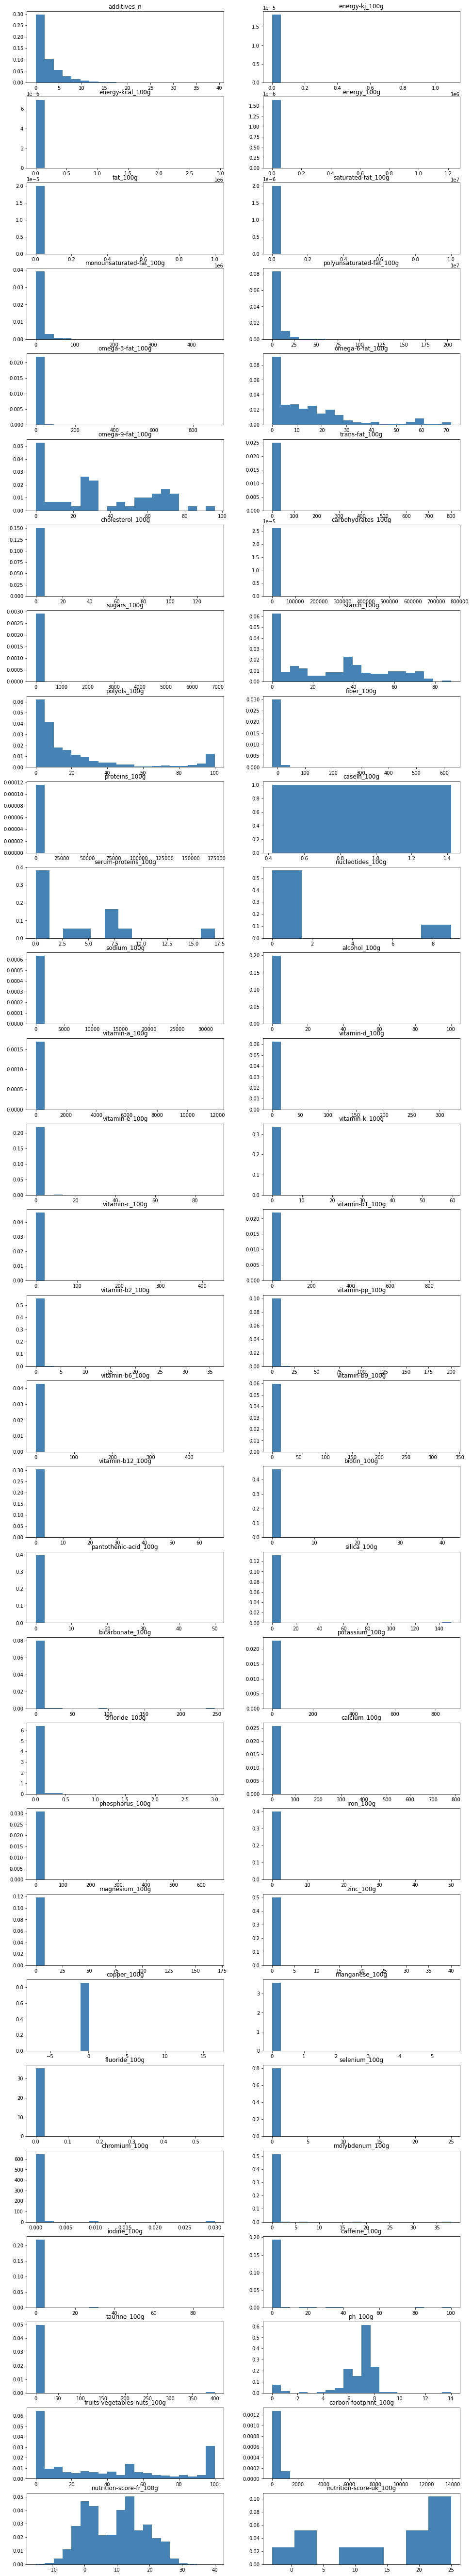

In [14]:
nb_line_plot = int(np.floor(len(float_var)/2)+1)
fig = plt.figure(figsize=(16, 100))

fig_count = 1
for var in float_var :#data.columns.intersection(list_of_nutri_facts):
    ax = fig.add_subplot(nb_line_plot,2, fig_count)
    nb_bins = min(20, len(np.unique(df[var].dropna().values)))
    ax.hist(df[var], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
    ax.set_title(var)
    fig_count += 1
plt.show()

In [23]:
data = df.copy()
colname = "additives_n"
possible_vals = possible_val_dict[colname]


help_to_set_outliers_vals(data, colname, possible_vals)

In [ ]:
import list_from_data_field
float_var = list_from_data_field.list_of_characteristics 

floa